In [1]:
from pathlib import Path
import pickle
from pprint import pprint
import sys
sys.path.append('..')

import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedGroupKFold
import yaml

from scripts import data

In [2]:
DIR_INPUTS = Path('../../data/inputs')
dir_path = Path.joinpath(DIR_INPUTS, 'csv_files')
DIR_PATH_CONFIGS = Path('../../data/configs/paths.yaml')
PROJECT_PATH = Path('../../data/models/d012-PMAD-lgbm-cv-week_cut')

if not PROJECT_PATH.exists():
    PROJECT_PATH.mkdir(parents=True)
    print(f'Create a directory at {PROJECT_PATH}')

COLUMNS_BASE = [
    'case_id',
    'date_decision',
    'MONTH',
    'WEEK_NUM',
    'target',
]
COLUMNS_BASE_TEST = [
    'case_id',
    'date_decision',
    'MONTH',
    'WEEK_NUM',
]

with open(DIR_PATH_CONFIGS, 'r') as f:
    dict_tables_all = yaml.safe_load(f)

pprint(dict_tables_all)

{0: {'static': ['static_0_0.csv', 'static_0_1.csv'],
     'static_cb': ['static_cb_0.csv']},
 1: {'applprev': ['applprev_1_0.csv', 'applprev_1_1.csv'],
     'credit_bureau_a': ['credit_bureau_a_1_0.csv',
                         'credit_bureau_a_1_1.csv',
                         'credit_bureau_a_1_2.csv',
                         'credit_bureau_a_1_3.csv'],
     'credit_bureau_b': ['credit_bureau_b_1.csv'],
     'debitcard': ['debitcard_1.csv'],
     'deposit': ['deposit_1.csv'],
     'other': ['other_1.csv'],
     'person': ['person_1.csv'],
     'tax_registry_a': ['tax_registry_a_1.csv'],
     'tax_registry_b': ['tax_registry_b_1.csv'],
     'tax_registry_c': ['tax_registry_c_1.csv']},
 2: {'applprev': ['applprev_2.csv'],
     'credit_bureau_a': ['credit_bureau_a_2_0.csv',
                         'credit_bureau_a_2_1.csv',
                         'credit_bureau_a_2_2.csv',
                         'credit_bureau_a_2_3.csv',
                         'credit_bureau_a_2_4.csv',
     

In [3]:
dict_tabels_use = {
    0: list(dict_tables_all[0].keys()),
    1: list(dict_tables_all[1].keys()),
    2: list(dict_tables_all[2].keys()),
}
category_columns_use = ['P', 'M', 'A', 'D']

pprint(dict_tabels_use)

{0: ['static', 'static_cb'],
 1: ['applprev',
     'credit_bureau_a',
     'credit_bureau_b',
     'debitcard',
     'deposit',
     'other',
     'person',
     'tax_registry_a',
     'tax_registry_b',
     'tax_registry_c'],
 2: ['applprev', 'credit_bureau_a', 'credit_bureau_b', 'person']}


In [4]:
df_train_merger = data.DataFrameMerger(dict_tables_all, dict_tabels_use, category_columns_use, dir_path)
df_base_train, dict_df_train = df_train_merger.load_concat('train')
dict_df_train = df_train_merger.aggregate(dict_df_train)
df_train = df_train_merger.merge(df_base_train, dict_df_train)

base (1526659, 5)


/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:94: DtypeWarning: Columns (20,45,46,53,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))
/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:94: DtypeWarning: Columns (20,45,46,56,57,84,143,146,167) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))


static (1526659, 77)


/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:94: DtypeWarning: Columns (1,2,3,4,7,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))


static_cb (1500476, 19)


/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:94: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))
/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:94: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))


applprev (1221522, 28)


/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:94: DtypeWarning: Columns (11,12,14,30,44,54) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))


credit_bureau_a (1386273, 50)


/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:94: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))


credit_bureau_b (36500, 33)
debitcard (111772, 5)
deposit (105111, 4)
other (51109, 6)


/Users/suzukiyuto/kaggle-works/home-credit-competition/src/notebooks/../scripts/data.py:94: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ = pd.read_csv(Path.joinpath(self.dir_path, mode, f'{mode}_{p}'))


person (1526659, 13)
tax_registry_a (457934, 4)
tax_registry_b (150732, 4)
tax_registry_c (482265, 4)
applprev (1221522, 2)
credit_bureau_a (1385288, 11)
credit_bureau_b (36446, 4)
person (1435041, 7)


In [5]:
# df_train.to_parquet('../../data/processed/train-d012.parquet')
df_train = pd.read_parquet('../../data/processed/train-d012.parquet')

display(df_train)

,case_id,date_decision,MONTH,WEEK_NUM,target,actualdpdtolerance_344P,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,...,2_pmts_overdue_1152A,2_pmts_dpdvalue_108P,2_pmts_pmtsoverdue_635A,2_pmts_date_1107D,2_addres_district_368M,2_addres_zip_823M,2_conts_role_79M,2_empls_economicalst_849M,2_empls_employer_name_740M,2_empls_employedfrom_796D
0,0,2019-01-03,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,None,None,None
1,1,2019-01-03,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,None,None,None
2,2,2019-01-04,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,None,None,None
3,3,2019-01-03,201901,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,None,None,None
4,4,2019-01-04,201901,0,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0,0.0,-23.0,-43.0,-23.0,0.0,...,NaN,NaN,NaN,None,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,None
1526655,2703451,2020-10-05,202010,91,0,0.0,-18.0,-12.0,-18.0,0.0,...,NaN,NaN,NaN,None,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,None
1526656,2703452,2020-10-05,202010,91,0,0.0,-12.0,NaN,-16.0,1.0,...,NaN,NaN,NaN,None,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,None
1526657,2703453,2020-10-05,202010,91,0,0.0,-33.0,-64.0,-34.0,0.0,...,NaN,NaN,NaN,None,a55475b1,a55475b1,a55475b1,a55475b1,a55475b1,None


In [6]:
dict_columns = {0:[], 1:[], 2:[]}
for k in df_train.columns:
    if k.startswith('2_'):
        dict_columns[2].append(k)
    elif k.startswith('1_'):
        dict_columns[1].append(k)
    else:
        dict_columns[0].append(k)

for k, v in dict_columns.items():
    print(k, len(v))

0 99
1 141
2 20


In [6]:
df_train_processed = data.preprocess(df_train, category_columns_use, mode='train')
y = df_train_processed[COLUMNS_BASE]
X = df_train_processed.drop(columns=COLUMNS_BASE)

In [8]:
display(X)
display(X.dtypes)
display(y)

,actualdpdtolerance_344P,avgdbddpdlast24m_3658932P,avgdbddpdlast3m_4187120P,avgdbdtollast24m_4525197P,avgdpdtolclosure24_3658938P,avgmaxdpdlast9m_3716943P,maxdbddpdlast1m_3658939P,maxdbddpdtollast12m_3658940P,maxdbddpdtollast6m_4187119P,maxdpdfrom6mto36m_3546853P,...,1_processingdate_168D_day,1_processingdate_168D_weekday,2_pmts_date_1107D_year,2_pmts_date_1107D_month,2_pmts_date_1107D_day,2_pmts_date_1107D_weekday,2_empls_employedfrom_796D_year,2_empls_employedfrom_796D_month,2_empls_employedfrom_796D_day,2_empls_employedfrom_796D_weekday
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526654,0.0,-23.0,-43.0,-23.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1526655,0.0,-18.0,-12.0,-18.0,0.0,0.0,0.0,2.0,2.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1526656,0.0,-12.0,NaN,-16.0,1.0,NaN,NaN,-27.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1526657,0.0,-33.0,-64.0,-34.0,0.0,0.0,-66.0,0.0,-33.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


actualdpdtolerance_344P              float64
avgdbddpdlast24m_3658932P            float64
avgdbddpdlast3m_4187120P             float64
avgdbdtollast24m_4525197P            float64
avgdpdtolclosure24_3658938P          float64
                                      ...   
2_pmts_date_1107D_weekday            float64
2_empls_employedfrom_796D_year       float64
2_empls_employedfrom_796D_month      float64
2_empls_employedfrom_796D_day        float64
2_empls_employedfrom_796D_weekday    float64
Length: 426, dtype: object

,case_id,date_decision,MONTH,WEEK_NUM,target
0,0,2019-01-03,201901,0,0
1,1,2019-01-03,201901,0,0
2,2,2019-01-04,201901,0,0
3,3,2019-01-03,201901,0,0
4,4,2019-01-04,201901,0,1
...,...,...,...,...,...
1526654,2703450,2020-10-05,202010,91,0
1526655,2703451,2020-10-05,202010,91,0
1526656,2703452,2020-10-05,202010,91,0
1526657,2703453,2020-10-05,202010,91,0


In [7]:
X.to_parquet(Path.joinpath(PROJECT_PATH, 'X.parquet'))
y.to_parquet(Path.joinpath(PROJECT_PATH, 'y.parquet'))

In [3]:
X = pd.read_parquet(Path.joinpath(PROJECT_PATH, 'X.parquet'))
y = pd.read_parquet(Path.joinpath(PROJECT_PATH, 'y.parquet'))

In [11]:
print(X.shape, y.shape)

(1526659, 426) (1526659, 5)


In [4]:
params = {
    'objective': 'binary',
    'metric': ['binary_logoss', 'auc', 'average_precision'],
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'seed': 42,
    'max_depth': 5,
    'num_leaves': 31,
}

In [5]:
X, X_later_weeks = X[y['WEEK_NUM'] < 50], X[y['WEEK_NUM'] >= 50]
y, y_later_weeks = y[y['WEEK_NUM'] < 50], y[y['WEEK_NUM'] >= 50]

In [6]:
skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
models = []
y_preds_valid = []
idx_valid = []
for n, (train_index, valid_index) in enumerate(skf.split(X, y['target'], groups=y['WEEK_NUM'])):
    print(f'Fold {n+1}')
    dataset_train = lgb.Dataset(X.iloc[train_index], y.iloc[train_index]['target'])
    dataset_valid = lgb.Dataset(X.iloc[valid_index], y.iloc[valid_index]['target'])
    print(f'Train: {len(train_index)}, Valid: {len(valid_index)}')
    
    model = lgb.train(
        params,
        dataset_train,
        num_boost_round=100_000,
        valid_sets=[dataset_train, dataset_valid],
        callbacks=[
            lgb.early_stopping(100, first_metric_only=True),
            lgb.log_evaluation(100),
        ],
    )
    models.append(model)
    y_pred_valid = model.predict(X.iloc[valid_index])
    y_preds_valid.append(y_pred_valid)
    idx_valid.append(valid_index)

y_preds_valid = np.concatenate(y_preds_valid)
idx_valid = np.concatenate(idx_valid)

Fold 1
Train: 815479, Valid: 188278
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.840598	training's average_precision: 0.192299	valid_1's auc: 0.817475	valid_1's average_precision: 0.136465
[200]	training's auc: 0.860758	training's average_precision: 0.239371	valid_1's auc: 0.82309	valid_1's average_precision: 0.141654
[300]	training's auc: 0.873799	training's average_precision: 0.284769	valid_1's auc: 0.825046	valid_1's average_precision: 0.14368
[400]	training's auc: 0.884527	training's average_precision: 0.326509	valid_1's auc: 0.82563	valid_1's average_precision: 0.144786
[500]	training's auc: 0.894029	training's average_precision: 0.367224	valid_1's auc: 0.825665	valid_1's average_precision: 0.145181
Early stopping, best iteration is:
[440]	training's auc: 0.888698	training's average_precision: 0.344469	valid_1's auc: 0.825826	valid_1's average_precision: 0.144659
Evaluated only: auc
Fold 2
Train: 808890, Valid: 194867
Training until validat

In [7]:
y_preds_later_weeks = []
for i, model in enumerate(models):
    y_pred_later_weeks = model.predict(X_later_weeks)
    y_preds_later_weeks.append(y_pred_later_weeks)
y_preds_later_weeks = np.mean(y_preds_later_weeks, axis=0)

In [8]:
for i, model in enumerate(models):
    with open(Path.joinpath(PROJECT_PATH, f'model_{i}.pkl'), 'wb') as f:
        pickle.dump(model, f)

# save y_preds_valid
np.save(Path.joinpath(PROJECT_PATH, 'y_preds_valid.npy'), y_preds_valid)
np.save(Path.joinpath(PROJECT_PATH, 'idx_valid.npy'), idx_valid)
np.save(Path.joinpath(PROJECT_PATH, 'y_preds_later_weeks.npy'), y_preds_later_weeks)

In [10]:
y_concat = pd.concat([y.iloc[idx_valid], y_later_weeks])
y_preds_concat = np.concatenate([y_preds_valid, y_preds_later_weeks])

print(y_concat.shape, y_preds_concat.shape)

(1526659, 5) (1526659,)


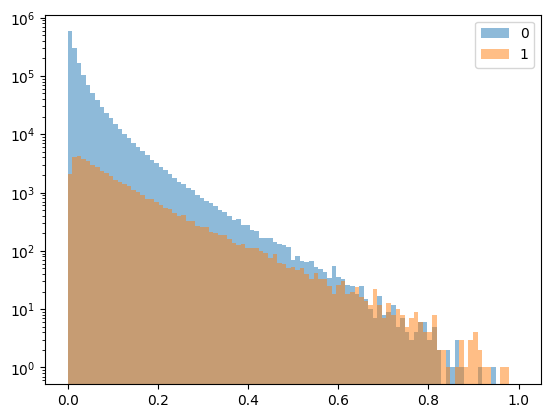

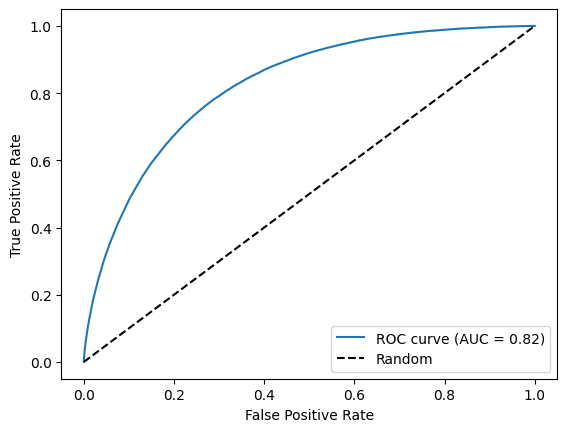

0.6277738946253765


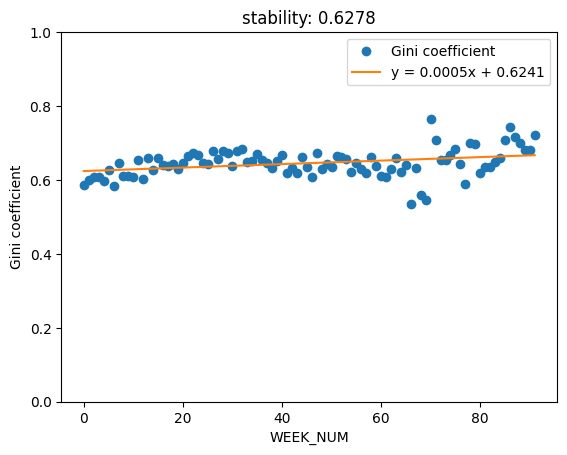

In [11]:
evaluator = data.Evaluator(y_concat, y_preds_concat, save_path=PROJECT_PATH)

evaluator.plot_pred(is_log=True)
evaluator.plot_roc()
df_gini_weeks, stability = evaluator.plot_gini()